In [1]:
import os
from datetime import datetime
from typing import Dict, Tuple, Any
from tqdm import tqdm
import pickle

import math
import numpy as np
import pandas as pd

import cv2
import albumentations
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau

import timm

In [2]:
# ---------------------------------------
# parameters

MODEL_DIR = './model_checkpoints/'
DATA_DIR = '../input/'
LOG_DIR = './logs/'
DEVICE = 'cuda:0'
MODEL_NAME = 'rexnet_200'

TRAIN_STEP = 0
FOLD = 0

IMAGE_SIZE = 256
BATCH_SIZE = 64
NUM_EPOCHS = 10
NUM_WORKERS = 4
LR = 1e-4
USE_AMP = True


In [3]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

In [4]:
dffull = pd.read_csv(os.path.join(DATA_DIR, 'train_full.csv'))

In [5]:
landmark_set = set(df['landmark_id'].unique())

In [30]:
dffull.loc[dffull['id'] == 'fb09f1e98c6d2f70', 'url'].tolist()

['http://upload.wikimedia.org/wikipedia/commons/3/3c/Luitpoldpark_Muenchen-11.jpg']

In [6]:
dffull['filtered_landmark'] = dffull['landmark_id'].apply(lambda x: x in landmark_set)

In [15]:
df_filtered = dffull.loc[dffull['filtered_landmark'] == True].copy()

In [16]:
df_filtered['filepath'] = df_filtered['id'].apply(lambda x: os.path.join(DATA_DIR, 'gldv2_full', x[0], x[1], x[2], f'{x}.jpg'))

In [28]:
nan_idx = [51729, 58418, 89570, 207804, 247399, 435129, 464522, 492557, 493305, 520145, 540587, 593833, 602810, 607030, 615114, 615793, 668572, 719194, 723510, 746219, 778021, 803135, 803344, 822590, 882202, 914065, 1024174, 1034640, 1072742, 1073455, 1084606, 1130207, 1217659, 1229739, 1335025, 1335206, 1408577, 1409026, 1413990, 1461958, 1475818, 1538471, 1552183, 1581086, 1715899, 1715943, 1763315, 1804912, 1831264, 1912638, 1920452, 1955757, 1985471, 1987043, 2081172, 2105031, 2113132, 2115408, 2248505, 2250243, 2347364, 2349762, 2411457, 2591314, 2629247, 2660044, 2679405, 2692707, 2777677, 2792521, 2800375, 2829086, 2964862, 2983418, 2987483, 3088850, 3130596, 3214329]

In [33]:
lm_set = df['landmark_id'].unique()

In [35]:
tocheck_id = []
for idx in nan_idx:
    tocheck_id = df_filtered.iloc[idx].landmark_id
    print(tocheck_id, tocheck_id in lm_set)

42539 True
200279 True
74556 True
32228 True
67929 True
179293 True
158291 True
74556 True
55649 True
77340 True
74556 True
173336 True
54576 True
105523 True
173336 True
173336 True
193239 True
173336 True
195279 True
173336 True
51746 True
104457 True
25804 True
50212 True
42211 True
195290 True
87029 True
74556 True
85928 True
166885 True
190834 True
173336 True
4226 True
48184 True
74556 True
174833 True
74556 True
5967 True
123819 True
80908 True
157913 True
96825 True
198111 True
86276 True
128938 True
117808 True
56325 True
199450 True
26689 True
134900 True
62408 True
97981 True
134900 True
120541 True
89587 True
177501 True
181865 True
135318 True
151797 True
26670 True
45993 True
109703 True
183883 True
189788 True
15696 True
74556 True
58421 True
117750 True
74556 True
74556 True
190929 True
187196 True
132490 True
123819 True
142465 True
29826 True
177501 True
157831 True


In [30]:
df_filtered.iloc[nan_idx[2]]

id                                                    3328857ccef38da6
url                  https://upload.wikimedia.org/wikipedia/commons...
landmark_id                                                     200279
filtered_landmark                                                 True
filepath                ../input/gldv2_full/3/3/2/3328857ccef38da6.jpg
Name: 75169, dtype: object

In [20]:
import matplotlib.pyplot as plt

158291


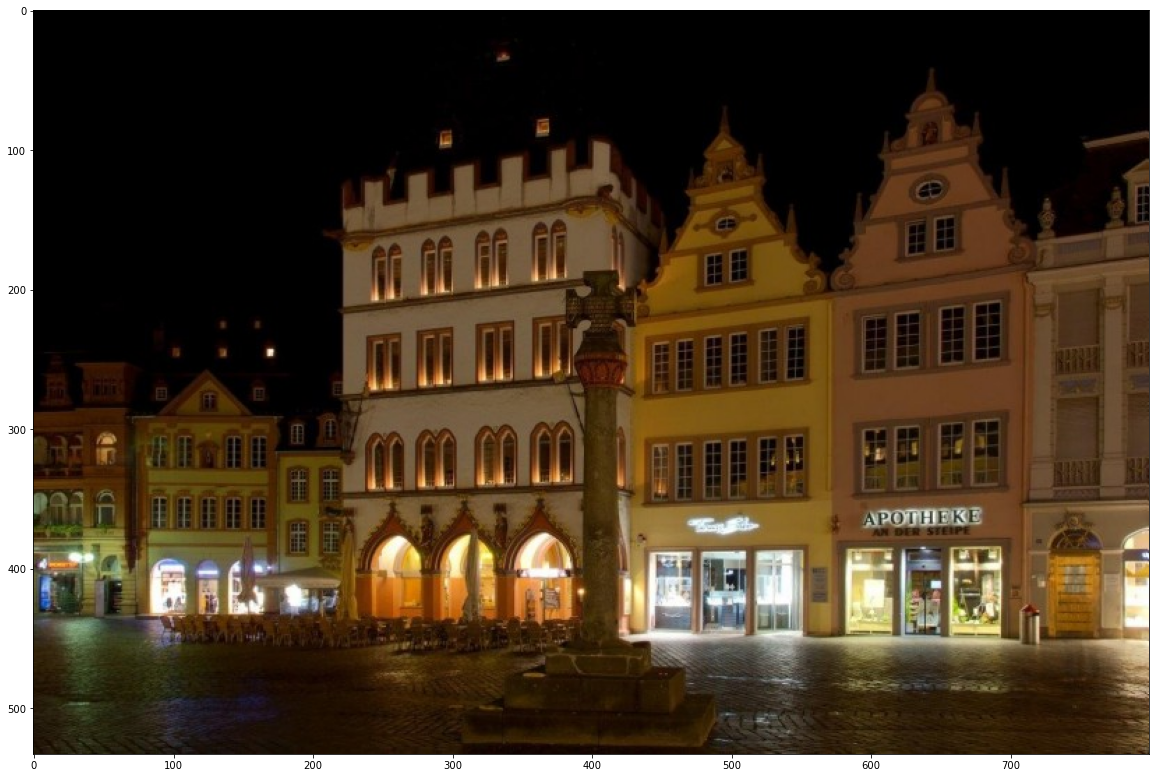

In [50]:
img = cv2.imread(df_filtered.iloc[464522].filepath)
print(df_filtered.iloc[464522].landmark_id)
_, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(img[:, :, ::-1])

In [39]:
df['filepath'] = df['id'].apply(lambda x: os.path.join(DATA_DIR, 'gldv2_full', x[0], x[1], x[2], f'{x}.jpg'))

In [67]:
img = cv2.imread(df.loc[df['landmark_id'] == 158291].iloc[15].filepath)
_, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(img[:, :, ::-1])

IndexError: single positional indexer is out-of-bounds

In [ ]:
img = cv2.imread(df_filtered.iloc[58418].filepath)
_, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(img[:, :, ::-1])

In [39]:
np.save("./embeddings/trainfull_embedding_filter", dffull.loc[dffull['filtered_landmark'] == True].index.values)

In [40]:
train_embedding = np.load('./embeddings/effnetb3_600_fold1_epoch5_trainfull_embeddings.npy')

In [42]:
trainfull_filter = dffull.loc[dffull['filtered_landmark'] == True].index.values

In [44]:
dffull.head()

,id,url,landmark_id,filtered_landmark
0,6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820,True
1,202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169,True
2,3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914,True
3,e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140,True
4,4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474,True


In [54]:
dffull_filtered = dffull.loc[dffull['filtered_landmark'] == True, 'landmark_id']

In [64]:
np.save('./embeddings/trainfullfiltered_embeddings_targets', dffull_filtered.values)

In [43]:
trainfull_filter

array([      0,       1,       2, ..., 4132911, 4132912, 4132913])

In [46]:
train_embedding = train_embedding[trainfull_filter]

In [52]:
train_embedding.shape

(3223078, 512)

In [49]:
np.save('./embeddings/effnetb3_600_fold1_epoch5_trainfullfiltered_embeddings', train_embedding)

In [24]:
df['old_filepath'] = df['id'].apply(lambda x: os.path.join(DATA_DIR, 'train', x[0], x[1], x[2], f'{x}.jpg'))

In [5]:
df['new_filepath'] = df['id'].apply(lambda x: os.path.join(DATA_DIR, 'gldv2_full', x[0], x[1], x[2], f'{x}.jpg'))

In [6]:
df.head()

,id,landmark_id,old_filepath,new_filepath
0,17660ef415d37059,1,../input/train/1/7/6/17660ef415d37059.jpg,../input/gldv2_full/1/7/6/17660ef415d37059.jpg
1,92b6290d571448f6,1,../input/train/9/2/b/92b6290d571448f6.jpg,../input/gldv2_full/9/2/b/92b6290d571448f6.jpg
2,cd41bf948edc0340,1,../input/train/c/d/4/cd41bf948edc0340.jpg,../input/gldv2_full/c/d/4/cd41bf948edc0340.jpg
3,fb09f1e98c6d2f70,1,../input/train/f/b/0/fb09f1e98c6d2f70.jpg,../input/gldv2_full/f/b/0/fb09f1e98c6d2f70.jpg
4,25c9dfc7ea69838d,7,../input/train/2/5/c/25c9dfc7ea69838d.jpg,../input/gldv2_full/2/5/c/25c9dfc7ea69838d.jpg


In [9]:
import matplotlib.pyplot as plt

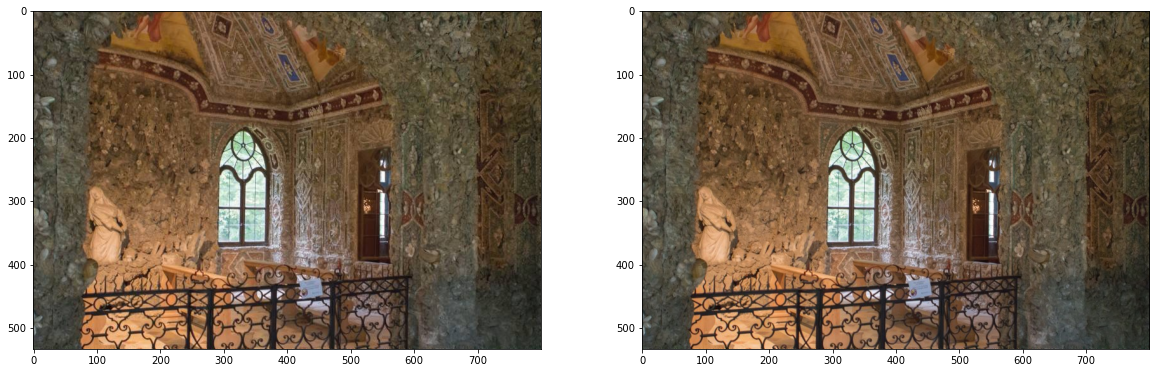

In [24]:
idx = 198412
img0 = cv2.imread(df['old_filepath'].iloc[idx])
img1 = cv2.imread(df['new_filepath'].iloc[idx])

_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img0[:, :, ::-1])
ax[1].imshow(img1[:, :, ::-1])

In [27]:
for i in tqdm(range(df.shape[0])):
    assert os.path.exists(df['new_filepath'].iloc[i])

100%|██████████| 1580470/1580470 [00:22<00:00, 70717.52it/s] 
